# Bill Cobb's Vehicle Dynamics Professional's July 2024 Challenge - #2

Given the output of a constant speed chirp steer test, produce the following vehicle metrics:

* Understeer gradient
* Yaw velocity by SWA steady-state gain
* Yaw velocity by SWA peak magnitude
* Yaw velocity by SWA frequency at peak magnitude
* Yaw velocity by SWA peak to steady-state ratio
* Yaw velocity by SWA damping ratio
* Yaw velocity by SWA bandwidth
* Yaw velocity by SWA time constant
* Any other metrics you can think of...

The vehicle is a generic car with non-linear steering and non-linear tires.

The original challenge from Bill Cobb:
    
> Produce these results from a frequency response test.  The file only contains yaw velocity by steer data from a steering input chirp.
> The Math also directly applies to Ayg by Steer, Sideslip by Steer, Roll by Ayg, Sideslip by Ayg, etc.
> Extra credit for Yaw Moment (without the extra Mz components) by Steer vs frequency.  (WF= 1000 kg, WR= 600 kg.)

In [1]:
%matplotlib widget

In [2]:
import dataclasses
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import pprint

from typing import Optional, Tuple

In [3]:
plt.style.use('seaborn-v0_8')

## Part 1: Define constants

We are given known quantities of the vehicle under test. Define them as constants.

In [4]:
VEHICLE_WB = 2.745  # m
VEHICLE_SR = 20.0  # rad/rad
VEHICLE_WF = 1000  # kg
VEHICLE_WR = 600  # kg
VEHICLE_M = VEHICLE_WF + VEHICLE_WR
VEHICLE_LA = VEHICLE_WB * (VEHICLE_WR / VEHICLE_M)
VEHICLE_LB = VEHICLE_WB * (VEHICLE_WF / VEHICLE_M)

Use constants for column header names to make it easier to access.

In [5]:
# Provided columns
COLUMN_TIME = "TIME, sec"
COLUMN_SPEED = "SPEED, kph"
COLUMN_STEER = "STEER, deg"
COLUMN_YAWVEL = "YAWVEL, deg/sec"

# Computed time domain columns
COLUMN_SPEED_SI = "SPEED, m/s"
COLUMN_STEER_SI = "STEER, rad"
COLUMN_DELTA_SI = "DELTA, rad"
COLUMN_YAWVEL_SI = "YAWVEL, rad/sec"

# Computed frequency domain columns
COLUMN_YAWBYDELTA_W = "W, 1/sec"
COLUMN_YAWBYDELTA_MAG = "MAG, 1/sec"
COLUMN_YAWBYDELTA_PHASE = 'PHASE, rad'

# Generic column names
COLUMN_W = "W"
COLUMN_MAG = "MAG"
COLUMN_PHASE = "PHASE"

Define common conversion factors.

In [6]:
STD_G = 9.81
DEG2RAD = np.pi / 180.0
RAD2DEG = 1 / DEG2RAD
KPH2MPS = 1000 / 3600.0
MPS2KPH = 1 / RAD2DEG
RADS2HZ = 0.5 / np.pi
HZ2RADS = 2 * np.pi

## Part 2: Data Wrangling

### Load in the data

Read in the data and sanitize it for consumption. The data has the following form:
    
| Row number | Description | Sample |
| ---------- | ----------- | ------ |
| Line 1     | Comment header describing the contents of the CSV and relevant vehicle parameters | `"BZ3 Nonlinear Vehicle Dynamics Simulation Frequency Response  WB=2745 SR=20.00"` |
| Line 2     | Column header names and units | `"TIME, sec";"SPEED, kph";"STEER, deg";"YAWVEL, deg/sec";                                                                                                                                                                                                                                                                                                                                                                            ;` |
| Line 3+    | Time series data | `0.000    ;100.000  ;-0.000   ;0.000     ` |

In [7]:
FILE_PATH = "../data/marc2.txt"

In [8]:
df = pl.read_csv(FILE_PATH, skip_rows=1, columns=range(4), separator=";").with_columns(
    pl.col("*").str.extract(r"(^-?\d+[.\d]*)").str.to_decimal()
)
df

"TIME, sec","SPEED, kph","STEER, deg","YAWVEL, deg/sec"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]"
0.000,100.000,0.000,0.000
0.010,100.000,0.000,0.000
0.020,100.000,0.000,0.000
0.030,100.000,0.000,0.000
0.040,100.000,0.000,0.000
…,…,…,…
40.920,100.000,0.000,0.000
40.930,100.000,0.000,0.000
40.940,100.000,0.000,0.000


### Convert to SI units

Perform all calculations in SI units.

In [9]:
df = df.with_columns(
    (pl.col(COLUMN_SPEED).cast(pl.Float32) * KPH2MPS).alias(COLUMN_SPEED_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD).alias(COLUMN_STEER_SI),
    (pl.col(COLUMN_YAWVEL).cast(pl.Float32) * DEG2RAD).alias(COLUMN_YAWVEL_SI),
)
df

"TIME, sec","SPEED, kph","STEER, deg","YAWVEL, deg/sec","SPEED, m/s","STEER, rad","YAWVEL, rad/sec"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32
0.000,100.000,0.000,0.000,27.777779,0.0,0.0
0.010,100.000,0.000,0.000,27.777779,0.0,0.0
0.020,100.000,0.000,0.000,27.777779,0.0,0.0
0.030,100.000,0.000,0.000,27.777779,0.0,0.0
0.040,100.000,0.000,0.000,27.777779,0.0,0.0
…,…,…,…,…,…,…
40.920,100.000,0.000,0.000,27.777779,0.0,0.0
40.930,100.000,0.000,0.000,27.777779,0.0,0.0
40.940,100.000,0.000,0.000,27.777779,0.0,0.0


### Visualize provided data

Plot the timeseries to see what we are working with.

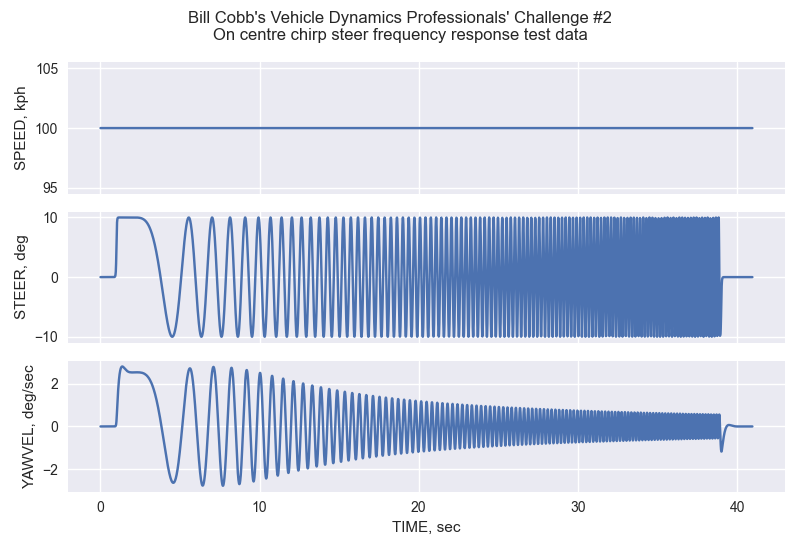

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True)

# Plot
columns = [COLUMN_SPEED, COLUMN_STEER, COLUMN_YAWVEL]
for ax, col in zip(axes, columns):
    ax.plot(df[COLUMN_TIME], df[col])
    ax.set_ylabel(col)

# Labels
axes[2].set_xlabel(COLUMN_TIME)

# Title
fig.suptitle("Bill Cobb's Vehicle Dynamics Professionals' Challenge #2\nOn centre chirp steer frequency response test data")

plt.tight_layout()
plt.show()

## Part 3: Nyquist-Shannon Sanity Check

Before we proceed, we need to make sure that our sampling rate is sufficiently high to avoid aliasing.


In [11]:
REQUIRED_BANDWIDTH = 5  # Hz
REQUIRED_LOGRATE = REQUIRED_BANDWIDTH * 2

In [12]:
# For some reason, Polars returns null when computing the series median or mode.
# Use max() instead.
dt = df[COLUMN_TIME].diff(null_behavior='drop').max()

print(f"Time step: {dt} s")
print(f"Sample rate: {1 / float(dt):.1f} Hz")
print(f"Required bandwidth: {REQUIRED_BANDWIDTH} Hz")
print(f"Required sample rate: {REQUIRED_LOGRATE} Hz")
print(f"Is sample rate > 2x the required sample rate?: {1 / float(dt) > 2 * REQUIRED_LOGRATE}")

Time step: 0.010 s
Sample rate: 100.0 Hz
Required bandwidth: 5 Hz
Required sample rate: 10 Hz
Is sample rate > 2x the required sample rate?: True


## Part 4: Frequency domain analysis

Given the signal $\delta(t)$ and $r(t)$, compute the gain in the frequency domain $\frac{R(f)}{\delta(f)}$. This transformation is achieved by taking an FFT of each signal and dividing the absolute magnitude.

$$
\frac{R(f)}{\delta(f)} = \frac{FFT(r(t))}{FFT(\delta(t))}
$$

Where:
* $R$ is yaw velocity [rad/s]
* $\delta$ is the road wheel angle [rad]

Consideration of the steering ratio is addressed in post-processing.

### Compute math channels.

All operations are done in SI units with respect to the road wheel angle.

In [13]:
df = df.with_columns(
    (pl.col(COLUMN_STEER_SI) / VEHICLE_SR).alias(COLUMN_DELTA_SI)
)
df

"TIME, sec","SPEED, kph","STEER, deg","YAWVEL, deg/sec","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, rad"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32
0.000,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
0.010,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
0.020,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
0.030,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
0.040,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
…,…,…,…,…,…,…,…
40.920,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
40.930,100.000,0.000,0.000,27.777779,0.0,0.0,0.0
40.940,100.000,0.000,0.000,27.777779,0.0,0.0,0.0


### Compute the frequency response from experimental data

Recall that the yaw velocity by steer frequency response can be calculated from the following relationship.

$$
\frac{R(f)}{\delta(f)} = \frac{FFT(r(t))}{FFT(\delta(t))}
$$

In [14]:
spectrum = sp.fft.fft(df[COLUMN_YAWVEL_SI].to_numpy()) / sp.fft.fft(
    df[COLUMN_DELTA_SI].to_numpy()
)

# Freqency response dataframe (fdf)
fdf = pl.DataFrame(
    [
        pl.Series(name=COLUMN_YAWBYDELTA_W, values=sp.fft.fftfreq(len(df), float(dt))),
        pl.Series(name=COLUMN_YAWBYDELTA_MAG, values=np.abs(spectrum)),
        pl.Series(name=COLUMN_YAWBYDELTA_PHASE, values=np.angle(spectrum)),
    ]
)

Prepare the frequency response data for system identification. Response is skew symmetric due to real input signal. Drop frequency content beyond 10 Hz.

In [15]:
FREQUENCY_CUTOFF = 10

In [16]:
fdf = fdf.filter(pl.col(COLUMN_YAWBYDELTA_W).is_between(0, FREQUENCY_CUTOFF))
fdf

"W, 1/sec","MAG, 1/sec","PHASE, rad"
f64,f32,f32
0.0,5.057945,0.0
0.024408,5.059226,-0.00758
0.048816,5.062668,-0.015205
0.073224,5.068668,-0.022929
0.097632,5.07634,-0.030849
…,…,…
9.885282,0.65547,-1.517639
9.90969,0.624455,-1.522799
9.934098,0.635824,-1.565304


### Visualize the frequency response data

Plot the frequency response to see what we are working with.

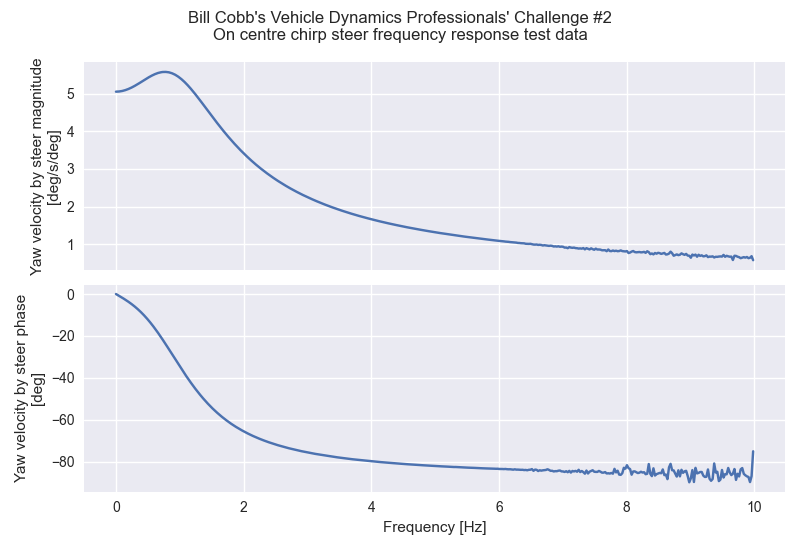

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(fdf[COLUMN_YAWBYDELTA_W], fdf[COLUMN_YAWBYDELTA_MAG])
axes[1].plot(fdf[COLUMN_YAWBYDELTA_W], fdf[COLUMN_YAWBYDELTA_PHASE] * RAD2DEG)

axes[0].set_ylabel("Yaw velocity by steer magnitude\n[deg/s/deg]")
axes[1].set_ylabel("Yaw velocity by steer phase\n[deg]")
axes[1].set_xlabel("Frequency [Hz]")

fig.suptitle("Bill Cobb's Vehicle Dynamics Professionals' Challenge #2\nOn centre chirp steer frequency response test data")

fig.tight_layout()
plt.show()

## Part 5: System Identification
For a linear, single-tracked bicycle model, the yaw velocity by steer response is given by the following transfer function.

$$
\frac{R(s)}{\delta(s)} = \frac{\frac{g l_{a} l_{b} m}{D_{f} I \left(l_{a} + l_{b}\right)} s + \frac{g^{2} l_{a} l_{b} m}{D_{f} D_{r} I u \left(l_{a} + l_{b}\right)}}{s^2 + \frac{\left(( D_f l_a + D_r l_b ) I + ( D_f l_b + D_r l_a ) m l_a l_b \right) g}{D_f D_r I u \left(l_{a} + l_{b}\right)}  s + \frac{\left((D_f - D_r) u^{2} + (l_{a} + l_{b}) g\right) g l_{a} l_{b} m }{D_f D_r I u^{2} \left(l_{a} + l_{b}\right)}}
$$

The challenge requires us to identify three vehicle parameters. These parameters are as follows.

* $D_f$ front cornering compliance
* $D_r$ rear cornering compliance
* $I$ yaw inertia

To identify these vehicle parameters, we perform a least-squares regression to minimize the squared error between the measured and predicted magnitude of yaw velocity by steer response.

$$
\min \sum_{i=1}^{N} \left( \left|\frac{R_{pred}(s_i)}{\delta_{pred}(s_i)}\right| - \frac{R_{meas}(f_i)}{\delta_{meas}(f_i)} \right)^2
$$

### Develop the vehicle model

Define the parameters and the equations of motion for a linear single-track bicycle model. The service returns a transfer function representing the vehicle.

In [18]:
@dataclasses.dataclass
class LinearSingleTrackVehicle:
    """
    Parameters for a linear single-tracked bicycle model.
    """
    g: float
    l_a: float
    l_b: float
    m: float
    D_f: float  # rad/g
    D_r: float  # rad/g
    I: float
    u: float
    sr: float  # Steering ratio
    
class LinearSingleTrackVehicleService:
    """
    Computation service for operations that act on LinearSingleTrackVehicle objects.
    """ 
    def get_denominator_coefficients(self, v: LinearSingleTrackVehicle, u: Optional[float] = None):
        u = u or v.u

        b2 = 1
        b1 = (v.g / (v.I * v.D_f * v.D_r * u * (v.l_a + v.l_b))) * (v.I * v.D_f * v.l_a + v.I * v.D_r * v.l_b + v.D_f * v.l_a * v.l_b * v.l_b * v.m + v.D_r * v.l_a * v.l_a * v.l_b * v.m)
        b0 = (v.g * v.l_a * v.l_b * v.m) * (v.D_f * u * u - v.D_r * u * u + v.g * v.l_a + v.g * v.l_b) / (v.I * v.D_f * v.D_r * u * u * (v.l_a + v.l_b))

        return np.array([b2, b1, b0])

    def get_yawrate_coefficients(self, v: LinearSingleTrackVehicle, u: Optional[float] = None):
        u = u or v.u

        a1 = (v.g * v.l_a * v.l_b * v.m) / (v.D_f * v.I * (v.l_a + v.l_b))
        a0 = (v.g * v.g * v.l_a * v.l_b * v.m) / (v.D_f * v.D_r * v.I * u * (v.l_a + v.l_b))
        den = self.get_denominator_coefficients(v, u)

        return np.array([a1, a0]), den


    def get_analysis_yawrate_tf(self, v: LinearSingleTrackVehicle, u: Optional[float] = None) -> sp.signal.TransferFunction:
        """
        Generates the classical formulation of the yaw rate response for a
        linear single-tracked bicycle model. Uses the road wheel angle as the
        input.
        """
        num, den = self.get_yawrate_coefficients(v, u)
        
        return sp.signal.TransferFunction(num, den)
    
    def get_practical_yawrate_tf(self, v: LinearSingleTrackVehicle, u: Optional[float] = None) -> sp.signal.TransferFunction:
        """
        Generates the practical formulation of the yaw rate transfer function
        with units of deg/s per 100 deg SWA.
        """ 
        
        num, den = self.get_yawrate_coefficients(v, u)
        num *= 100 / v.sr

        return sp.signal.TransferFunction(num, den)
    
    def get_analysis_yawmoment_tf(self, v: LinearSingleTrackVehicle, u: Optional[float] = None) -> sp.signal.TransferFunction:
        num, den = self.get_yawrate_coefficients(v, u)
        np.append(num, 0)
        num *= v.I
        
        return sp.signal.TransferFunction(num, den)

    def get_practical_yawmoment_tf(self, v: LinearSingleTrackVehicle, u: Optional[float] = None) -> sp.signal.TransferFunction:
        num, den = self.get_yawrate_coefficients(v, u)
        np.append(num, 0)
        num *= v.I * 100 / v.sr
        
        return sp.signal.TransferFunction(num, den)

### Define baseline vehicle parameters

The following vehicle represents our initial guess at what the missing parameters are. Known parameters are populated at this time.

The initial guess for yaw inertia is based on using a dynamic index (DI) of 1. Recall that the dynamic index is related to the yaw radius of gyration, the vehicle wheelbase and the vehicle weight distribution. The yaw inertia is estimated based on the following relationships.

$$ \text{DI} = \frac{k^2}{l_a l_b} $$
$$ k^2 = \frac{I}{m} $$


In [19]:
baseline_vehicle = LinearSingleTrackVehicle(
    g=STD_G,
    l_a=VEHICLE_LA,
    l_b=VEHICLE_LB,
    m=VEHICLE_M,
    D_f=4 * DEG2RAD,
    D_r=2 * DEG2RAD,
    I=VEHICLE_LA * VEHICLE_LB * VEHICLE_M,
    u=100 * KPH2MPS,
    sr=VEHICLE_SR,
)
baseline_vehicle

LinearSingleTrackVehicle(g=9.81, l_a=1.029375, l_b=1.7156250000000002, m=1600, D_f=0.06981317007977318, D_r=0.03490658503988659, I=2825.634375, u=27.77777777777778, sr=20.0)

### Regression

Define the objective function. Recall, we want to minimize the squared error
between the predicted and measured magnitude response. The solution to the
optimization will return a vehicle model that represents the vehicle measured
in the experimental data.

$$
\min \sum_{i=1}^{N} \left( \left|\frac{R(s_i)}{\delta(s_i)}\right| - \frac{FFT(r(t))}{FFT(\delta(t))} \right)^2
$$

In [20]:
vehicle_service = LinearSingleTrackVehicleService()


def objective(x):
    """
    Objective function for the optimization problem.
    """
    new_baseline_vehicle = dataclasses.replace(baseline_vehicle)
    new_baseline_vehicle.D_f = x[0]
    new_baseline_vehicle.D_r = x[1]
    new_baseline_vehicle.I = x[2]

    sys = vehicle_service.get_analysis_yawrate_tf(new_baseline_vehicle)
    w, mag, phase = sp.signal.bode(sys, w=fdf[COLUMN_YAWBYDELTA_W] * 2 * np.pi)

    error = fdf[COLUMN_YAWBYDELTA_MAG].to_numpy() - 10 ** (mag / 20)

    return np.sum(error * error)


result = sp.optimize.minimize(
    objective,
    [baseline_vehicle.D_f, baseline_vehicle.D_r, baseline_vehicle.I],
    method="Nelder-Mead",
)
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.09893484729325477
             x: [ 8.715e-02  5.224e-02  2.848e+03]
           nit: 109
          nfev: 202
 final_simplex: (array([[ 8.715e-02,  5.224e-02,  2.848e+03],
                       [ 8.715e-02,  5.224e-02,  2.848e+03],
                       [ 8.715e-02,  5.224e-02,  2.848e+03],
                       [ 8.715e-02,  5.224e-02,  2.848e+03]]), array([ 9.893e-02,  9.893e-02,  9.893e-02,  9.893e-02]))

### Identify vehicle parameters

Based on the regression, the following parameters are identified.

| Parameter | Value |
| --------- | ----- |
| $D_f$     | $5$ deg/G |
| $D_r$     | $2$ deg/G |
| $I$       | $2848$ kg*m^2 |

In [21]:
print(f"IDENTIFIED VEHICLE PARAMETERS")
print(f"D_f = {result.x[0] * RAD2DEG:.2f} deg/G")
print(f"D_r = {result.x[1] * RAD2DEG:.2f} deg/G")
print(f"I = {result.x[2]:.2f} kg*m^2")

IDENTIFIED VEHICLE PARAMETERS
D_f = 4.99 deg/G
D_r = 2.99 deg/G
I = 2848.19 kg*m^2


### Build the identified vehicle model

Construct the vehicle parameters based on the identified parameters to be consumed for analysis.

In [22]:
vehicle = dataclasses.replace(baseline_vehicle)
vehicle.D_f = result.x[0]
vehicle.D_r = result.x[1]
vehicle.I = result.x[2]
vehicle

LinearSingleTrackVehicle(g=9.81, l_a=1.029375, l_b=1.7156250000000002, m=1600, D_f=np.float64(0.08714502367949803), D_r=np.float64(0.05224133050132005), I=np.float64(2848.188267335915), u=27.77777777777778, sr=20.0)

## Part 6: Extract metrics

Given the vehicle parameters, simulate the relevant time and frequency domain
responses and compute the desired metrics.


### Result containers

Define dataclasses to store the results of the analysis. This is boilerplate code.

In [23]:
@dataclasses.dataclass
class FrequencyResponseMetrics:
    vehicle: LinearSingleTrackVehicle 

    dc_gain: float
    peak_gain: float
    peak_gain_freq: float  # rad/s
    peak_dc_ratio: float
    natural_freq: float  # rad/s
    damped_natural_freq: float
    damping_ratio: float
    half_power: float
    bandwidth: float  # rad/s

@dataclasses.dataclass
class StepResponseMetrics:
    vehicle: LinearSingleTrackVehicle 

    risetime: float
    settlingtime: float
    overshoot: float
    overshoot_mag: float
    overshoot_time: float

### Develop metrics

Define the methods for computing the desired metrics. Given the a transfer function in the form of the following.

$$G(s) = \frac{a_1s + a_0}{s^2 + b_1s + b_0}$$

The natural frequency and damping ratio can be computed by relating the system to the denominator of a harmonic oscillator. Recall.

$$H(s) = \frac{\omega_n^2}{s^2 + 2\omega_n^2s + \omega_n^2}$$

The natural frequency and damping ratio can be computed by relating coefficients.

$$\omega_n = \sqrt{b_0}$$
$$\zeta = \frac{b_1}{2\omega_n}$$

The damped natural frequency can be computed from the natural frequency and damping ratio.

$$\omega_d = \omega_n \sqrt{1 - \zeta^2}$$

The DC gain of the system can be computed by setting $s = j\omega = 0$.

$$G(0) = \frac{a_0}{b_0}$$

All other metrics are computed by simulating either the time response of the frequency response.

In [24]:
class LinearSingleTrackVehicleAnalysisService:
    """
    Analysis service. Computes metrics given the vehicle parameters.
    * Frequency in rad/s (for math reasons)
    * Magnitude in absolute terms
    """

    def __init__(
        self,
        vehicle,
        vehicle_service: Optional[LinearSingleTrackVehicleService] = None,
        channel: str = "yawrate",
        mode: str = "practical",
        bode_max_freq: float = 5,
        bode_n: int = 1000,
        step_n: int = 2000

    ) -> None:
        self.vehicle = vehicle
        self.vehicle_service = vehicle_service or LinearSingleTrackVehicleService()
        self.channel = channel
        self.mode = mode
        self.bode_max_freq = bode_max_freq
        self.bode_n = bode_n
        self.step_n = step_n

    def compute_frequency_domain_metrics(self):
        sys = self.get_transfer_function()
        frf = self.get_frequency_response()

        return FrequencyResponseMetrics(
            vehicle=self.vehicle,
            dc_gain=self.dc_gain(sys),
            peak_gain=self.peak_magnitude(frf),
            peak_gain_freq=self.peak_magnitude_freq(frf),
            peak_dc_ratio=self.peak_dc_ratio(sys, frf),
            natural_freq=self.natural_freq(),
            damped_natural_freq=self.damped_natural_freq(),
            damping_ratio=self.damping_ratio(),
            half_power=self.half_power(sys),
            bandwidth=self.bandwidth(sys, frf),
        )

    def compute_time_domain_metrics(self):
        sys = self.get_transfer_function()
        step = self.get_step_response()

        overshoot, max_value, max_value_time = self.overshoot(sys, step)

        return StepResponseMetrics(
            vehicle=self.vehicle,
            risetime=self.risetime(sys, step),
            settlingtime=self.settling_time(sys, step),
            overshoot=overshoot,
            overshoot_mag=max_value,
            overshoot_time=max_value_time
        )

    def get_transfer_function(
        self,
        channel: Optional[str] = None,
        mode: Optional[str] = None,
        u: Optional[float] = None,
    ) -> sp.signal.TransferFunction:
        channel = channel or self.channel
        mode = mode or self.mode

        func_map = {
            ("yawrate", "analysis"): self.vehicle_service.get_analysis_yawrate_tf,
            ("yawrate", "practical"): self.vehicle_service.get_practical_yawrate_tf,
            ("yawmoment", "analysis"): self.vehicle_service.get_analysis_yawmoment_tf,
            ("yawmoment", "practical"): self.vehicle_service.get_practical_yawmoment_tf,
        }

        return func_map[(channel, mode)](self.vehicle, u=u)

    def get_frequency_response(self) -> pl.DataFrame:
        w = np.linspace(0, self.bode_max_freq, self.bode_n) * HZ2RADS

        sys = self.get_transfer_function()
        w, mag, phase = sp.signal.bode(sys, w=w)
        return pl.DataFrame(
            [
                pl.Series(name=COLUMN_W, values=w),
                pl.Series(name=COLUMN_MAG, values=10 ** (mag / 20)),
                pl.Series(name=COLUMN_PHASE, values=phase),
            ]
        )

    def get_step_response(self) -> pl.DataFrame:
        sys = self.get_transfer_function()
        t, y = sp.signal.step(sys, N=self.step_n)
        return pl.DataFrame(
            [
                pl.Series(name=COLUMN_TIME, values=t),
                pl.Series(name=COLUMN_YAWVEL, values=y),
            ]
        )

    def dc_gain(self, sys: sp.signal.TransferFunction):
        return sys.num[-1] / sys.den[-1]

    def natural_freq(self):
        den = self.vehicle_service.get_denominator_coefficients(self.vehicle)
        return np.sqrt(den[-1])

    def damped_natural_freq(self):
        wn = self.natural_freq()
        zeta = self.damping_ratio()

        return wn * np.sqrt((1 - zeta * zeta))

    def damping_ratio(self):
        wn = self.natural_freq()
        den = self.vehicle_service.get_denominator_coefficients(self.vehicle)

        return den[1] / 2 / wn

    def half_power(self, sys: sp.signal.TransferFunction):
        dc_gain = 20 * np.log10(self.dc_gain(sys))
        return 10 ** ((dc_gain - 3) / 20)

    def bandwidth(
        self, sys: sp.signal.TransferFunction, frequency_response: pl.DataFrame
    ):
        half_power = self.half_power(sys)
        row = frequency_response.filter(pl.col(COLUMN_MAG) < half_power)
        row = row.head(1)

        return np.squeeze(row[COLUMN_W].to_numpy()[0])

    def peak_magnitude(self, frequency_response: pl.DataFrame):
        return frequency_response[COLUMN_MAG].max()

    def peak_magnitude_freq(self, frequency_response: pl.DataFrame):
        row = frequency_response.filter(pl.col(COLUMN_MAG) == pl.col(COLUMN_MAG).max())
        row = row.head(1)

        return np.squeeze(row[COLUMN_W].to_numpy())

    def peak_dc_ratio(
        self, sys: sp.signal.TransferFunction, frequency_response: pl.DataFrame
    ):
        peak_magnitude = self.peak_magnitude(frequency_response)
        dc_gain = self.dc_gain(sys)

        return peak_magnitude / dc_gain
    
    def risetime(self, sys: sp.signal.TransferFunction, step_response: pl.DataFrame, criteria=5):
        dc_gain = self.dc_gain(sys)
        
        select = step_response.filter(pl.col(COLUMN_YAWVEL) <= dc_gain*(1-criteria/100))
        row = select.tail(1)
        
        return row[COLUMN_TIME].to_numpy()[0]

    def settling_time(self, sys: sp.signal.TransferFunction, step_response: pl.DataFrame, criteria=5):
        dc_gain = self.dc_gain(sys)
        
        select = step_response.filter(pl.col(COLUMN_YAWVEL).is_between(dc_gain * (1-criteria/100), dc_gain * (1+criteria/100)).not_())
        row = select.tail(1)
        
        return row[COLUMN_TIME].to_numpy()[0]

    def overshoot(self, sys: sp.signal.TransferFunction, step_response: pl.DataFrame):
        dc_gain = self.dc_gain(sys)
        row = step_response.filter(pl.col(COLUMN_YAWVEL) == pl.col(COLUMN_YAWVEL).max())
        row = row.head(1)
        max_value = row[COLUMN_YAWVEL].to_numpy()[0]
        time = row[COLUMN_TIME].to_numpy()[0]
        
        return max_value / dc_gain, max_value, time 


Compute the metrics using the defined methods and package them in a data structure. Both the time and frequency domain metrics are pretty printed for your convenience.

In [25]:
analysis_service = LinearSingleTrackVehicleAnalysisService(vehicle)
frf_metrics = analysis_service.compute_frequency_domain_metrics()
step_metrics = analysis_service.compute_time_domain_metrics()

Frequency domain metrics

In [26]:
print("Frequency domain metrics, frequency in rad/s")
pprint.pp(frf_metrics)

Frequency domain metrics, frequency in rad/s
FrequencyResponseMetrics(vehicle=LinearSingleTrackVehicle(g=9.81,
                                                          l_a=1.029375,
                                                          l_b=1.7156250000000002,
                                                          m=1600,
                                                          D_f=np.float64(0.08714502367949803),
                                                          D_r=np.float64(0.05224133050132005),
                                                          I=np.float64(2848.188267335915),
                                                          u=27.77777777777778,
                                                          sr=20.0),
                         dc_gain=np.float64(25.29691991923527),
                         peak_gain=27.908202203238474,
                         peak_gain_freq=array(4.78000083),
                         peak_dc_ratio=np.float64(1.10322530538

Step response metrics, unit step of 100 deg SWA

In [27]:
print("Step response metrics")
pprint.pp(step_metrics)

Step response metrics
StepResponseMetrics(vehicle=LinearSingleTrackVehicle(g=9.81,
                                                     l_a=1.029375,
                                                     l_b=1.7156250000000002,
                                                     m=1600,
                                                     D_f=np.float64(0.08714502367949803),
                                                     D_r=np.float64(0.05224133050132005),
                                                     I=np.float64(2848.188267335915),
                                                     u=27.77777777777778,
                                                     sr=20.0),
                    risetime=np.float64(0.19058070824745463),
                    settlingtime=np.float64(0.5736934630520647),
                    overshoot=np.float64(1.1084116070207837),
                    overshoot_mag=np.float64(28.039399660355638),
                    overshoot_time=np.float64(0.364900

## Step 7: Visualize the results

Produce a graph showing the frequency response and step response of the system, highlighting any relevant frequency domain and time domain metrics for the vehicle under test.

WARNING: Most of the code here is boilerplate plotting that is not fun to read.

In [28]:
sys = analysis_service.get_transfer_function()

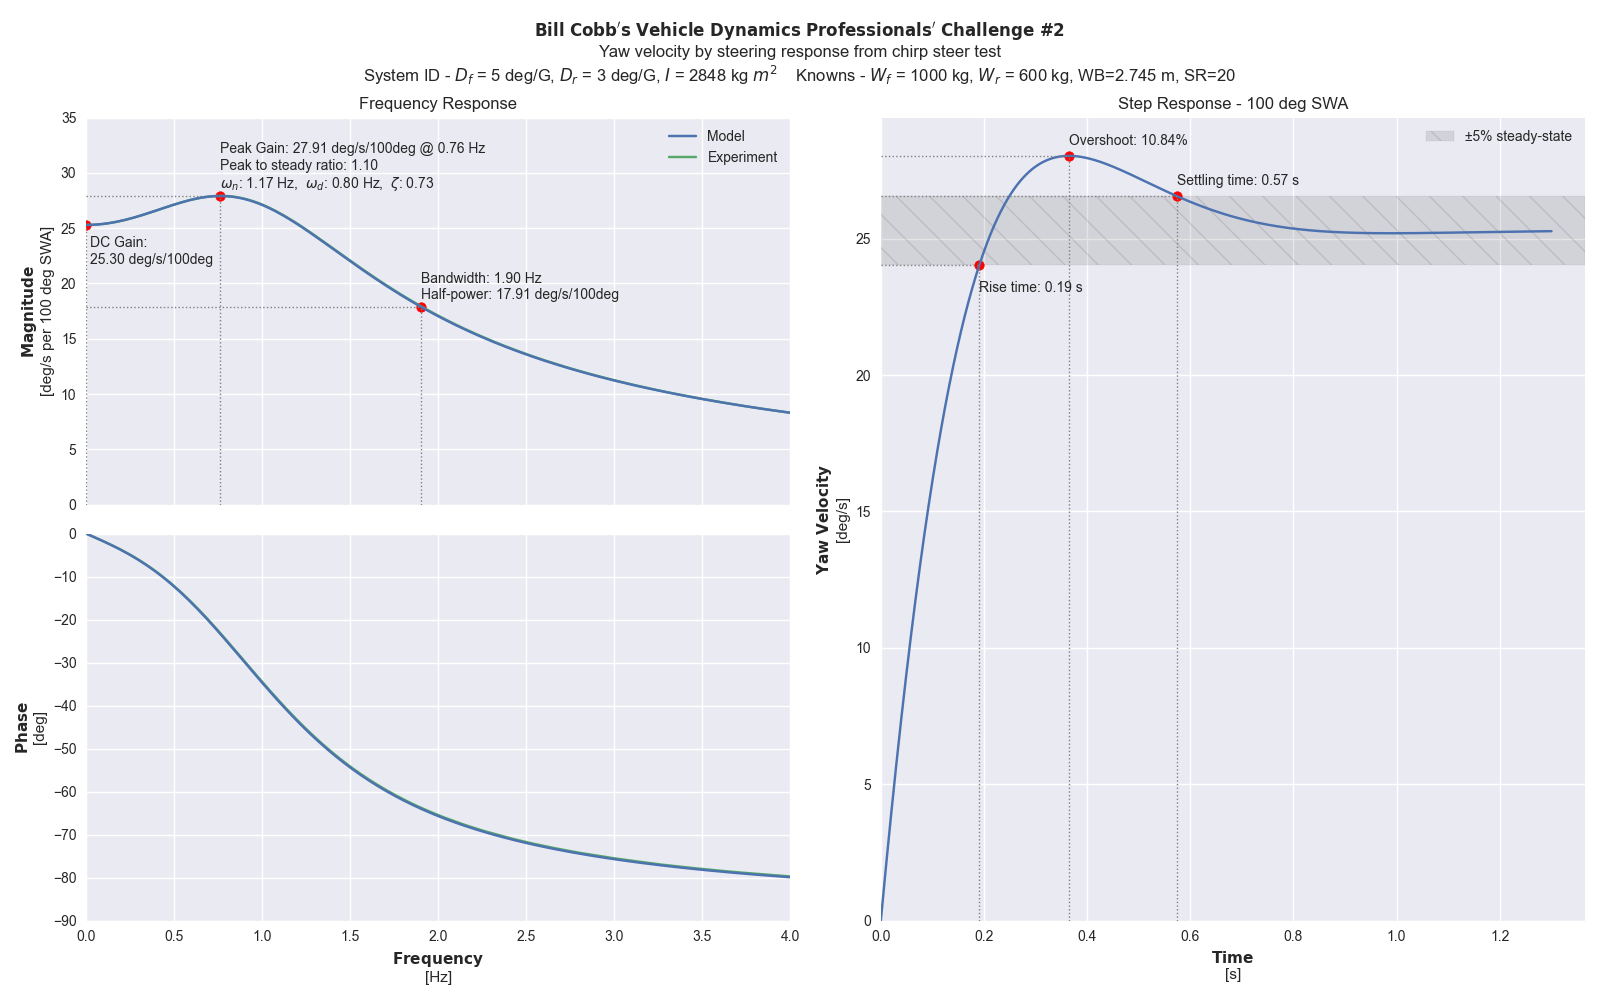

In [29]:
fig = plt.figure(figsize=(16, 10))
gridspec = fig.add_gridspec(nrows=2, ncols=2)

ax1 = fig.add_subplot(gridspec[0, 0])
ax2 = fig.add_subplot(gridspec[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gridspec[:, 1])

# BODE PLOT
# Frequency domain
w, mag, phase = sp.signal.bode(sys, w=fdf[COLUMN_YAWBYDELTA_W] * HZ2RADS)
w = w * RADS2HZ
mag = 10 ** (mag / 20)

ax1.plot(w, mag, label="Model", zorder=10)
ax2.plot(w, phase, label="Model", zorder=10)

# Experimental data
ax1.plot(
    fdf[COLUMN_YAWBYDELTA_W],
    fdf[COLUMN_YAWBYDELTA_MAG] * 100 / vehicle.sr,
    label="Experiment",
)
ax2.plot(
    fdf[COLUMN_YAWBYDELTA_W],
    fdf[COLUMN_YAWBYDELTA_PHASE] * 180 / np.pi,
    label="Experiment",
)

# Annotations
annotations_x = [
    0,
    frf_metrics.peak_gain_freq * RADS2HZ,
    frf_metrics.bandwidth * RADS2HZ,
]
annotations_y = [frf_metrics.dc_gain, frf_metrics.peak_gain, frf_metrics.half_power]
ax1.vlines(
    x=annotations_x,
    ymin=[0, 0, 0],
    ymax=annotations_y,
    linestyle="dotted",
    color="gray",
    linewidth=1,
    alpha=1,
)
ax1.hlines(
    y=annotations_y,
    xmin=[0, 0, 0],
    xmax=annotations_x,
    linestyle="dotted",
    color="gray",
    linewidth=1,
    alpha=1,
)
ax1.scatter(annotations_x, annotations_y, color="red")
ax1.annotate(
    f"DC Gain:\n{frf_metrics.dc_gain:.2f} deg/s/100deg",
    xy=(0.02, frf_metrics.dc_gain - 3.5),
)
ax1.annotate(
    f"Peak Gain: {frf_metrics.peak_gain:.2f} deg/s/100deg @ {frf_metrics.peak_gain_freq * RADS2HZ:.2f} Hz\n"
    f"Peak to steady ratio: {frf_metrics.peak_dc_ratio:.2f}\n"
    r"$\omega_n$: " + f"{frf_metrics.natural_freq * RADS2HZ:.2f} Hz,  "
    r"$\omega_d$: " + f"{frf_metrics.damped_natural_freq * RADS2HZ:.2f} Hz,  "
    r"$\zeta$: " + f"{frf_metrics.damping_ratio:.2f}",
    xy=(frf_metrics.peak_gain_freq * RADS2HZ, frf_metrics.peak_gain + 0.7),
)
ax1.annotate(
    f"Bandwidth: {frf_metrics.bandwidth * RADS2HZ:.2f} Hz\n"
    f"Half-power: {frf_metrics.half_power:.2f} deg/s/100deg",
    xy=(frf_metrics.bandwidth * RADS2HZ, frf_metrics.half_power + 0.7),
)

# Labels
ax1.set_title("Frequency Response")
ax1.set_ylabel(r"$\mathbf{Magnitude}$" + "\n" + "[deg/s per 100 deg SWA]")
ax2.set_ylabel(r"$\mathbf{Phase}$" + "\n" + "[deg]")
ax2.set_xlabel(r"$\mathbf{Frequency}$" + "\n" + "[Hz]")
plt.setp(ax1.get_xticklabels(), visible=False)

# Axis limits
ax1.set_ylim(bottom=0, top=35)
ax1.set_xlim(left=0, right=4)
ax2.set_ylim(top=0, bottom=-90)

ax1.legend()

# TIME RESPONSE
step = analysis_service.get_step_response()
ax3.plot(step[COLUMN_TIME], step[COLUMN_YAWVEL])
ax3.set_title("Step Response - 100 deg SWA")
ax3.set_xlabel(r"$\mathbf{Time}$" + "\n" + "[s]")
ax3.set_ylabel(r"$\mathbf{Yaw\ Velocity}$" + "\n" + "[deg/s]")

# Annotations
ax3.axhspan(
    frf_metrics.dc_gain * 0.95,
    frf_metrics.dc_gain * 1.05,
    color="black",
    alpha=0.1,
    label="±5% steady-state",
    hatch="\\",
)

annotations_x = (
    [step_metrics.risetime, step_metrics.overshoot_time, step_metrics.settlingtime],
)
annotations_y = [
    frf_metrics.dc_gain * 0.95,
    step_metrics.overshoot_mag,
    frf_metrics.dc_gain * 1.05,
]
ax3.vlines(
    annotations_x,
    ymin=[0, 0, 0],
    ymax=annotations_y,
    linestyle="dotted",
    color="gray",
    linewidth=1,
    alpha=1,
)
ax3.hlines(
    annotations_y,
    xmin=0,
    xmax=annotations_x,
    linestyle="dotted",
    color="gray",
    linewidth=1,
    alpha=1,
)
ax3.scatter(
    annotations_x,
    annotations_y,
    color="red",
)
ax3.annotate(
    f"Rise time: {step_metrics.risetime:.2f} s",
    xy=(step_metrics.risetime, frf_metrics.dc_gain * 0.95 - 1),
)
ax3.annotate(
    f"Overshoot: {100*(step_metrics.overshoot-1):.2f}%",
    xy=(step_metrics.overshoot_time, step_metrics.overshoot_mag + 0.4),
)
ax3.annotate(
    f"Settling time: {step_metrics.settlingtime:.2f} s",
    xy=(step_metrics.settlingtime, frf_metrics.dc_gain * 1.05 + 0.4),
)

# Axis limits
ax3.set_ylim(bottom=0)
ax3.set_xlim(left=0)

ax3.legend()

# Title
plt.suptitle(
    r"$\mathbf{Bill\ Cobb's\ Vehicle\ Dynamics\ Professionals'\ Challenge\ \#2}$"
    + "\n"
    + "Yaw velocity by steering response from chirp steer test"
    + "\n"
    + r"System ID - $D_f$ = 5 deg/G, $D_r$ = 3 deg/G, $I$ = 2848 kg $m^2$    Knowns - $W_f$ = 1000 kg, $W_r$ = 600 kg, WB=2.745 m, SR=20"
)

fig.tight_layout()
plt.show()